In [13]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from data import temperature
from data import sample_HC
from data import err_sample_HC
from data import err_temperature

squared_temperature = temperature**2  # K**2
C_div_T = sample_HC/temperature  # mJ/K**2.mol
err_C_divT = err_sample_HC/temperature


In [5]:
# Constantes et tableaux

k = 1.380649e-23
r = 8.31446261815324  # J/mol.K


In [17]:
# On ne prendra que les 65 premières valeurs
temp65 = temperature[:65]
HC65 = sample_HC[:65]
err_HC65 = err_sample_HC[:65]
# err_temperature n’est pas utilisé ici, sauf si nécessaire pour un calcul particulier

# 1. Préparation des données
# Calcul de x = temperature**2 et y = C/T
x_raw = (temp65 ** 2).astype('float32')  # forme (65,)
y_raw = (HC65 / temp65).astype('float32')  # forme (65,)
err_y = (err_HC65 / temp65).astype('float32')  # forme (65,)

# Reshape en (65, 1) pour Keras
x = x_raw.reshape(-1, 1)
y = y_raw.reshape(-1, 1)
err_y = err_y.reshape(-1, 1)

# 2. Normalisation manuelle de x
mean_x = np.mean(x, axis=0)
std_x = np.std(x, axis=0) + 1e-8
x_scaled = (x - mean_x) / std_x


In [18]:
# 3. Split train/val/test à l’intérieur des 65 points
# On mélange les indices pour éviter un ordre spécifique
indices = np.arange(65)
np.random.shuffle(indices)
# Par exemple 60% train, 20% val, 20% test
n_train = int(0.6 * 65)  # ≃39
n_val = int(0.2 * 65)    # ≃13
# Reste pour test
train_idx = indices[:n_train]
val_idx = indices[n_train:n_train + n_val]
test_idx = indices[n_train + n_val:]

x_train, y_train = x_scaled[train_idx], y[train_idx]
x_val, y_val     = x_scaled[val_idx],   y[val_idx]
x_test, y_test   = x_scaled[test_idx],  y[test_idx]

# 4. Poids optionnels basés sur l’incertitude
# Exemple : poids = 1/variance, régularisé pour éviter valeurs extrêmes
weights = 1.0 / (err_y[train_idx].flatten()**2 + 1e-6)
weights = weights / np.mean(weights)  # normalisation pour garder moyenne ~1


In [19]:
# 5. Définition du modèle
tf.random.set_seed(42)
model = keras.Sequential([
    keras.layers.Input(shape=(1,)),
    # Optionnel : on peut intégrer la normalisation comme couche :
    # keras.layers.Normalization(axis=-1, mean=mean_x, variance=(std_x**2)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1)
])
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse'
)

# 6. Callbacks pour early stopping et ajustement du LR
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
]

# 7. Entraînement sur les 65 points (avec split interne)
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    sample_weight=weights,
    epochs=500,
    callbacks=callbacks,
    verbose=1
)

# 8. Évaluation sur le petit jeu de test issu des 65 points
test_loss = model.evaluate(x_test, y_test, verbose=0)
print(f"Test MSE (sur les ~13 points test): {test_loss:.4f}")

# 9. Prédiction sur les 65 points pour tracé
pred65 = model.predict(x_scaled).flatten()
# Reconversion de l’axe x à l’échelle originale pour affichage si souhaité
x_orig = (x_scaled * std_x) + mean_x  # forme (65,1)


Epoch 1/500
2/2 [==============================] - 2s 528ms/step - loss: 405.8165 - val_loss: 620.7018 - lr: 0.0010
Epoch 2/500
2/2 [==============================] - 0s 106ms/step - loss: 404.3808 - val_loss: 619.2007 - lr: 0.0010
Epoch 3/500
2/2 [==============================] - 0s 116ms/step - loss: 402.9567 - val_loss: 617.7632 - lr: 0.0010
Epoch 4/500
2/2 [==============================] - 0s 85ms/step - loss: 401.6068 - val_loss: 616.4784 - lr: 0.0010
Epoch 5/500
2/2 [==============================] - 0s 102ms/step - loss: 400.1892 - val_loss: 615.2530 - lr: 0.0010
Epoch 6/500
2/2 [==============================] - 0s 108ms/step - loss: 398.9862 - val_loss: 614.1217 - lr: 0.0010
Epoch 7/500
2/2 [==============================] - 0s 225ms/step - loss: 397.8929 - val_loss: 613.0615 - lr: 0.0010
Epoch 8/500
2/2 [==============================] - 0s 290ms/step - loss: 396.8297 - val_loss: 612.0179 - lr: 0.0010
Epoch 9/500
2/2 [==============================] - 0s 242ms/step - loss: 

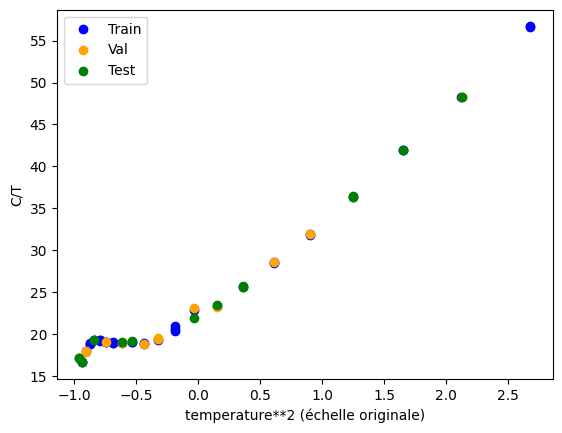

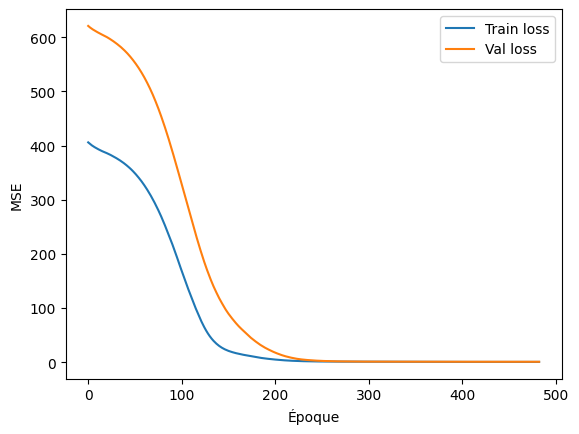

In [21]:
# 10. Tracés
plt.figure()
plt.scatter(x_train.flatten(), y_train.flatten(), color='blue', label='Train')
plt.scatter(x_val.flatten(), y_val.flatten(), color='orange', label='Val')
plt.scatter(x_test.flatten(), y_test.flatten(), color='green', label='Test')
# Tracé de la prédiction (on ordonne par x pour que la courbe soit lisse)
# On trie par x_orig pour une ligne continue
order = np.argsort(x_orig.flatten())
plt.xlabel('temperature**2 (échelle originale)')
plt.ylabel('C/T')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Époque')
plt.ylabel('MSE')
plt.legend()
plt.show()